# Building a CNN for object detection 

__Prerequisites__

- Custom Datasets
- CNNs

## What is detection?

Detection is the task of identifying **where** a particular object appears in an image/video.

![](images/real_time_object_detection.jpg)

In this notebook, we will train a CNN to detect people in images.

**The approach used in this notebook is really just a proof of concept, and it really just a demonstration of one way to formulate the problem.** In practice, it takes much more advanced models and algorithms to achieve useful results for detection.

In the file ```s40dataset.py``` there is a custom dataset which we have defined. Let's take a look at it.



(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x400 at 0x7FC5D87F1BB0>, tensor([0.4767, 0.5700, 0.7667, 0.8575]))


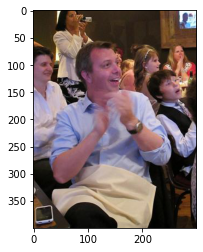

In [2]:
# IMPORTS
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from S40dataset import S40dataset
import matplotlib.pyplot as plt
import time

dataset = S40dataset()
print(dataset[0]) # print first example
img, bbox = dataset[0]
plt.imshow(img)

We can see that each item in the dataset is a tuple containing an image and a vector. The vector contains the xmin, ymin, xmax, ymax, given as the proportional distance across the image in the respective direction. These define the top left (xmin, ymin) and bottom right (xmax, ymax) coordinates of the bounding box.

Note that this dataset is for **single instance** object detection. There are no examples which contain multiple instances or have multiple label bounding boxes.

Our input is an image of different size varying around 400x400. The label for each image is 4 floats which represent the x and y value of the centre of the rectangle and as its height and width. The numbers are floats instead of integers as we do not directly use the pixel location as the label but normalize it w.r.t the height and width of the image. So our values range from 0-1.

Now we know what our data looks like, let's make our dataloaders. We'll need to apply some transforms to make sure all images have the same size, because our torch model expects inputs of a fixed size. We'll also need to convert the image from a PIL image into a torch tensor. Finally, because we are going to bootstrap from a pretrained model, we'll need to normalise the images in the same way that the original dataset was.

The drawing of the bounding box onto the image is a bit fiddly, so we've provided a method called ```show``` in the ```S40dataset.py``` file.

In [3]:
from S40dataset import show

#HYPERPARAMETER
batch_size = 4

# NORMALISE IN THE SAME WAY AS TORCH PRETRAINED MODEL'S INPUTS
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

img_size = 224*2

transform = transforms.Compose([# compose transforms 
    transforms.Resize((img_size, img_size)),# resize imgs
    transforms.ToTensor(), # convert PIL images into Torch Tensors
    normalize
])

# MAKE DATASET
dataset = S40dataset(transform=transform)# make the dataset and pass it our transforms

# SPLIT DATASET
train_len = int( 0.8 * len(dataset))
val_len = int( 0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len
train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len]) # split the dataset into train, test, validation

# MAKE DATALOADERS
train_loader = DataLoader( # make the training dataloader
    train_data, 
    batch_size = batch_size,
    shuffle=True
)

test_loader = DataLoader(test_data, batch_size=batch_size)

# SHOW A RANDOM EXAMPLE FROM THE DATASET
for i in test_loader:
    b = i
    break
import numpy as np
show(b)

Now let's make a conv net to perform this detection. But wait... what's the format of the output? Well the label is a 4-vector of values between 0-1. So that's what our detection model should output.

In [6]:
from torchvision import models

# CREATE MODEL
class DetectCNN(torch.nn.Module):# create class
    def __init__(self):# initialise
        super().__init__()         # initialise parent class
        self.conv_layers = models.vgg11(pretrained=True).features
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(512*14*14, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 4),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x): # define forward pass
        x = self.conv_layers(x) # forward pass through conv layers
        print(x.shape)
        x = x.view(-1, np.prod(x.shape[1:]))
        # x = x.view(-1, 64*46*46)# flatten conv output to pass to fully connected layers
        x = self.fc_layers(x)# pass through fc layers
        return x# return output

    def freeze(self):
        for param in self.conv_layers.parameters():
            param.requires_grad = False # remove from the computational graph

Let's now train the model

In [10]:
# HYPERPARAMETERS
epochs = 1
lr = 0.1
        
cnn = DetectCNN()# create instance of model
cnn.freeze()

criterion = torch.nn.MSELoss()# define loss function
optimiser = torch.optim.SGD(cnn.parameters(), lr=lr, weight_decay=0)# define optimiser

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter

def checkpoint_model(model, name):
    checkpoint = {
        'model': DetectCNN,
        'state_dict': model.state_dict(),
    }
    torch.save(checkpoint, f'trained_models/{name}')# save model

# TRAIN
def train(model, epochs):
    writer = SummaryWriter(log_dir=f'../../runs/detection/{time.time()}') # we will use this to show our models performance on a graph

    for epoch in range(epochs):
        for idx, batch in enumerate(train_loader):
            x, bndbox = batch    # unpack batch
            pred_bndbox = model(x)# forward pass
            #print('label:', bndbox, 'prediction:', pred_bndbox)
            loss = criterion(pred_bndbox, bndbox)     # compute loss for this batch
            optimiser.zero_grad()# zero gradients of optimiser
            loss.backward()     # backward pass (find rate of change of loss with respect to model parameters)
            optimiser.step() # take optimisation step
            print('Epoch:', epoch, 'Batch:', idx, 'Loss:', loss.item())
            writer.add_scalar('detection/Loss/Train', loss, epoch*len(train_loader) + idx)    # write loss to a graph
        checkpoint_model(model, f'{str(time.time())}-epoch-{epoch}')
    print('Training Complete. Final loss =',loss.item())

train(cnn, epochs)

torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 0 Loss: 0.0663023293018341
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 1 Loss: 0.04863491654396057
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 2 Loss: 0.034094251692295074
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 3 Loss: 0.03443475812673569
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 4 Loss: 0.03773593530058861
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 5 Loss: 0.02891894057393074
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 6 Loss: 0.011688655242323875
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 7 Loss: 0.026233768090605736
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 8 Loss: 0.01135651022195816
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 9 Loss: 0.018498072400689125
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 10 Loss: 0.012683110311627388
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 11 Loss: 0.0243147574365139
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch: 12 Loss: 0.020644428208470345
torch.Size([4, 512, 14, 14])
Epoch: 0 Batch:

KeyboardInterrupt: 

In [13]:
def visualise(model, n=10):
    model.eval()
    for idx, batch in enumerate(test_loader):
        print(type(batch))
        x, y = batch
        pred_bndbox = model(x)
        show(batch, pred_bndbox=pred_bndbox)
        if idx == n:
            break

In [14]:
visualise(cnn, n=10)

<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])
<class 'list'>
torch.Size([4, 512, 14, 14])


## Summary
- A very simple way to convert CNN's into detection algorithms is by training them to 

## Please note: this is a very naive approach and will not give great results
- much more complicated things have been done

If you are interested in exploring further how object detection works, you should look into:
- R-CNN
- Faster R-CNN
- YOLO (from version 1 to 3)

## Next steps
- [Recurrent Neural Networks](https://github.com/AI-Core/Recurrent-Neural-Networks/blob/master/Recurrent%20Neural%20Networks.ipynb)